# A Lightweight Concept Drift Detection and Adaptation Framework for IoT Data Streams 
This is the code for the paper entitiled "**A Lightweight Concept Drift Detection and Adaptation Framework for IoT Data Streams**" accepted in IEEE Internet of Things Magazine.  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 3: Proposed Optimized Adaptive and Sliding Windowing (OASW) method for concept drift detection and adaptation**  
Aims:  
&nbsp; 1): Develop a drift detection and adaptation method to handle concept drift   
&nbsp; 2): Obtain the optimized drift model using hyperparameter optimization techniques  

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from creme import metrics
from creme import stream
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Read the NSL-KDD dataset

In [2]:
df = pd.read_csv("NSL_KDD_binary(train+test).csv")
df1 = pd.read_csv("NSL_KDD_binary_train.csv")
df2 = pd.read_csv("NSL_KDD_binary_test.csv")

### Data sampling
Use the last 10% of training set and the entire test set

In [3]:
df_used = int(len(df1)*0.1) + len(df2)
df0 = df.iloc[-df_used:]

# df0=df0.sample(n=None, frac=0.1, replace=False, weights=None, random_state=None, axis=0)
# df0=df0.sort_index()

In [4]:
df0

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
113376,0,1,54,9,1132,366,0,0,0,0,...,148,0.88,0.08,0.03,0.01,0.00,0.0,0.00,0.00,0
113377,0,1,24,9,256,3123,0,0,0,0,...,255,1.00,0.00,0.01,0.02,0.00,0.0,0.00,0.00,0
113378,1,1,54,9,2215,333,0,0,0,0,...,99,0.39,0.08,0.00,0.00,0.02,0.0,0.00,0.00,0
113379,0,1,5,5,0,0,0,0,0,0,...,1,0.00,0.07,0.00,0.00,1.00,1.0,0.00,0.00,1
113380,0,1,56,5,0,0,0,0,0,0,...,1,0.00,0.08,0.00,0.00,1.00,1.0,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,1,49,9,794,333,0,0,0,0,...,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,0
148513,0,1,22,9,317,938,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,0
148514,0,1,22,9,54540,8314,0,0,0,2,...,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,1
148515,0,2,11,9,42,42,0,0,0,0,...,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0


## Train-test split
10% training set, and 90% test set

In [6]:
X = df0.drop(['label'],axis=1)
y = df0['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False, random_state = 0)

## Offline learning: LightGBM

In [7]:
classifier = lgb.LGBMClassifier()
# classifier = joblib.load('Optimized_lightGBM.pkl') 
classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test,predictions)))

Accuracy: 0.8420969424858507


# OASW method Development

## Define the OASW method

In [44]:
import time
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# a: warining threshold, b: drift threshold, win1: sliding window size, win2: adaptive window max size
def oasw_pso(params):

    a=abs(float(params['a']))
    b=abs(float(params['b']))
    win1=int(params['win1'])
    win2=int(params['win2'])
 
    i=0
    yt = []
    yp = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]
    
    metric = metrics.Accuracy()
    
    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)
    
    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, y_pred)  # update the metric

        # Store the y_test, y_pred, and x_test
        yt.append(yi)
        yp.append(y_pred)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:]) 
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)
            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1
    score=metric.get()
    print(str(a)+" "+str(b)+" "+str(win1)+" "+str(win2)+" "+str(score)) # Output the hyperparameter values and corresponding accuracy
    return {'loss': -score, 'status': STATUS_OK }
    

In [45]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
space = {
    'a': hp.quniform('a', 0.95, 0.99, 0.001),
    'b': hp.quniform('b', 0.90, 0.98, 0.001),
    'win1': hp.quniform('win1', 200, 1000, 50),
    'win2': hp.quniform('win2', 1000, 5000, 100),
}

t1=time.time()
best = fmin(fn=oasw,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print(t2-t1)

0.9570000000000001 0.925 600 1600 0.9487828011381622
0.977 0.96 700 4300 0.9487828011381622
0.965 0.901 300 4300 0.9487828011381622
0.981 0.905 600 4600 0.9487828011381622
0.985 0.9560000000000001 950 1400 0.9487828011381622
0.989 0.91 500 2100 0.9487828011381622
0.969 0.965 900 3800 0.9487828011381622
0.9530000000000001 0.972 1000 4300 0.9487828011381622
0.963 0.912 450 3800 0.9487828011381622
0.9580000000000001 0.9560000000000001 650 4100 0.9487828011381622
100%|███████████████████████████████████████████████| 10/10 [00:51<00:00,  5.14s/trial, best loss: -0.9487828011381622]
Hyperopt estimated optimum {'a': 0.9570000000000001, 'b': 0.925, 'win1': 600.0, 'win2': 1600.0}
51.43736743927002


In [26]:
def oasw(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    i=0
    yt = []
    yp = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]
    
    metric = metrics.Accuracy()
    
    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)
    
    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, y_pred)  # update the metric

        # Store the y_test, y_pred, and x_test
        yt.append(yi)
        yp.append(y_pred)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:]) 
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)
            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1
    score=metric.get()
    print(str(a)+" "+str(b)+" "+str(win1)+" "+str(win2)+" "+str(score)) # Output the hyperparameter values and corresponding accuracy
    return score

In [27]:
import optunity
import optunity.metrics

search = {
    'a': [0.95,0.99],
    'b': [0.90,0.98],
    'win1': [200,1000],
    'win2': [1000,5000],
         }

optimal_configuration, info, _ = optunity.maximize(oasw,
                                                  solver_name='particle swarm',
                                                  num_evals=10,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

0.963359375 0.94109375 711 2820 0.9405627568763846
0.968359375 0.91109375 411 3320 0.9509958899778705
0.988359375 0.95109375 811 1320 0.927600379386658
0.978359375 0.93109375 611 4320 0.9528928232690504
0.958359375 0.97109375 211 2320 0.9494151122352197
0.955859375 0.90609375 761 1070 0.9310780904204892
0.975859375 0.94609375 361 3070 0.9500474233322783
0.985859375 0.92609375 561 2070 0.9478343344925717
0.965859375 0.96609375 961 4070 0.900727157761619
0.960859375 0.93609375 261 1570 0.9503635788808115
{'a': 0.978359375, 'b': 0.93109375, 'win1': 610.9375, 'win2': 4320.3125}
Accuracy:0.9528928232690504


## Train the optimized OASW model with optimal hyperparameters
The accuracy change figure is also plotted

In [8]:
def oasw_plot(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)
    
    metric = metrics.Accuracy()
    metric2 = metrics.Accuracy()

    i = 0
    t = []
    yt = []
    yp = []
    m = []
    m2 = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]
    
    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)
    
    classifier2 = lgb.LGBMClassifier() # Train an offline LightGBM model as a comparison model
    classifier2.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, y_pred)  # update the metric

        y_pred2= classifier2.predict(xi2.reshape(1, -1)) 
        metric2 = metric2.update(yi, y_pred2)
        
        # Store the y_test, y_pred, x_test, and real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        m2.append(metric2.get()*100)
        xt.append(xi2)
        
        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:]) 
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)
            
            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1
    
    # Plot the accuracy change figure
    plt.rcParams.update({'font.size': 35})
    plt.ion() 
    plt.figure(1,figsize=(24,15)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='OASW+LightGBM, Avg Accuracy: %.2f%%'%(metric.get()*100))
    plt.plot(t,m2,'red',label='Offline LightGBM, Avg Avg Accuracy: %.2f%%'%(metric2.get()*100))
    
    #Plot the drift points
    for i in range(len(dr)):
        if i!=0:
            plt.scatter(dr[i],m[dr[i]],s=200,c='r')

    plt.legend(loc='best')
    plt.ylim(80, 101)
    plt.title('NSL-KDD', fontsize=40)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy(%)')

    plt.draw()

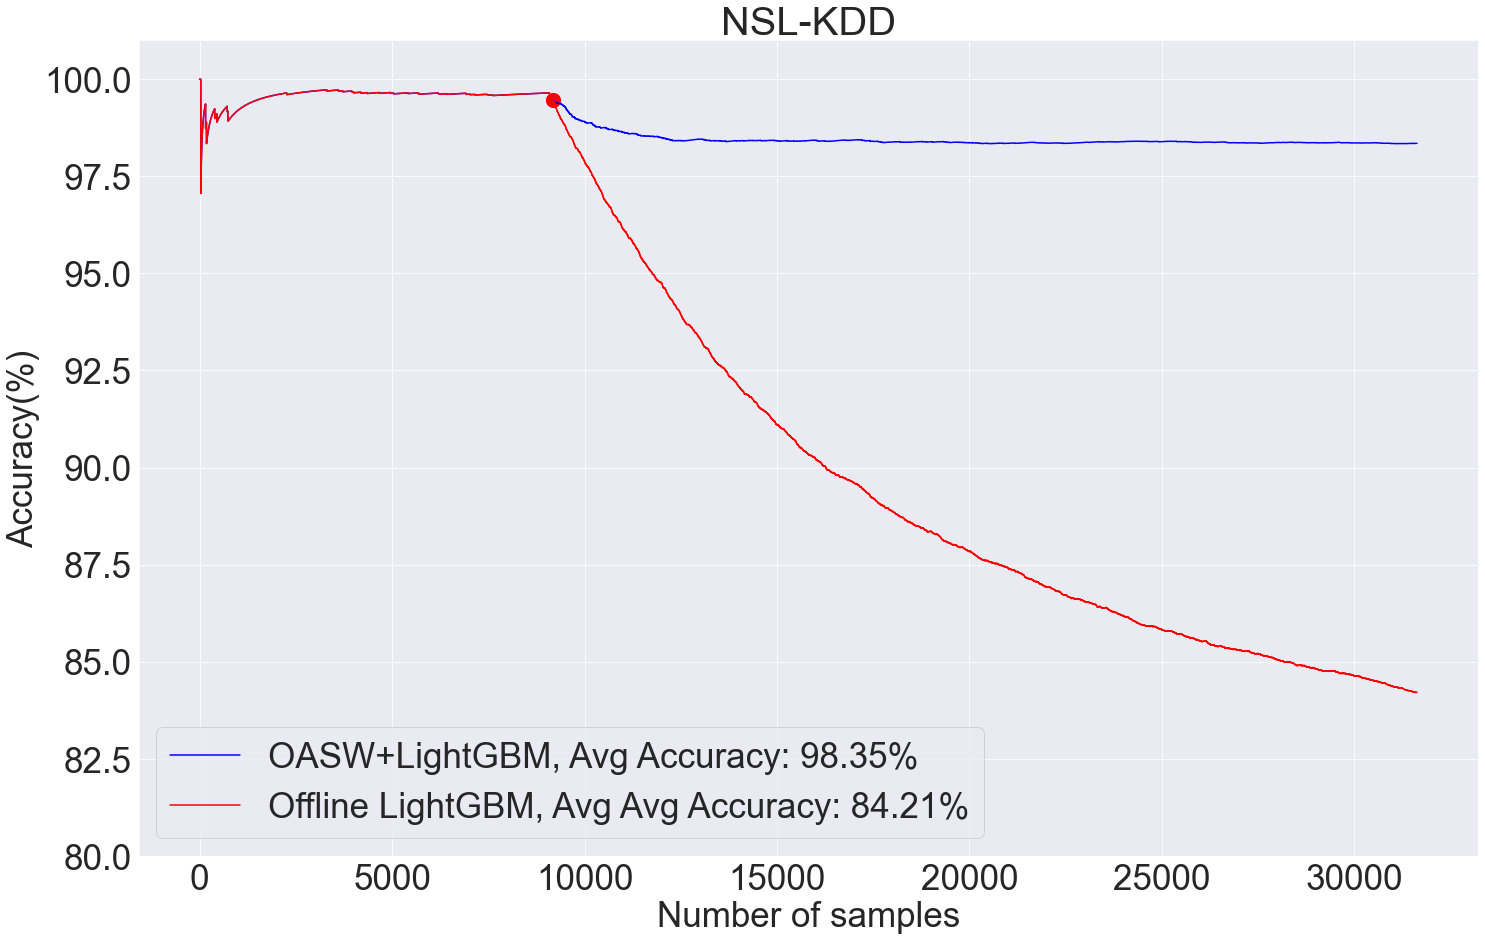

In [10]:
oasw_plot(a = 0.978, b = 0.954, win1 = 350, win2 = 3100)